# 🧬 Lab 3 — Visualization and Dimensionality Reduction in Bioinformatics

This lab explores **dimensionality reduction** and **clustering** for biological datasets such as RNA-seq.
We use both classical linear methods (PCA) and nonlinear methods (t-SNE, UMAP, Autoencoders).

### Covered Topics
- PCA (Principal Component Analysis)
- t-SNE (t-distributed Stochastic Neighbor Embedding)
- UMAP (Uniform Manifold Approximation and Projection)
- k-Means and Hierarchical Clustering
- PyTorch Autoencoder for nonlinear dimensionality reduction

⚙️ *Some heavy computations (t-SNE, UMAP) are mocked here but full runnable code is provided (commented out) for students with GPU or internet access.*


## 1️⃣ Setup and Imports

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score


In [3]:
# For autoencoders, preferably on Linux/Mac, uncomment
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset


## 2️⃣ Load and preprocess data

In [4]:

# Option A: Load a real GEO dataset (requires internet)
try:
    import GEOparse
    print("Downloading GSE10072 from GEO...")
    gse = GEOparse.get_GEO("GSE10072", destdir="./")
    
    # Get expression data
    expr_data = gse.pivot_samples('VALUE')
    
    # Get sample metadata
    sample_metadata = gse.phenotype_data
    
    # Create conditions based on sample characteristics
    # For GSE37704, we'll use a simple condition assignment
    n_samples = expr_data.shape[1]
    conditions = np.repeat(["Control", "Treatment"], n_samples // 2)
    if n_samples % 2 == 1:  # Handle odd number of samples
        conditions = np.append(conditions, ["Control"])
    
    # Create gene names
    n_genes = expr_data.shape[0]
    gene_names = [f"Gene_{i}" for i in range(n_genes)]
    
    # Create data DataFrame
    data = pd.DataFrame(expr_data.values, 
                       index=gene_names, 
                       columns=[f"Sample_{i}" for i in range(n_samples)])
    
    # Create metadata DataFrame
    meta = pd.DataFrame({
        "Sample": data.columns, 
        "Condition": conditions
    })
    
    print(f"Successfully loaded GEO dataset: {n_genes} genes, {n_samples} samples")
    
except Exception as e:
    print(f"Failed to download GEO data: {e}")
    print("Using synthetic dataset instead...")
    
    # Option B: Synthetic dataset fallback
    np.random.seed(42)
    n_genes, n_samples = 500, 60
    conditions = np.repeat(["Control", "Treatment"], n_samples // 2)
    
    # Generate synthetic expression data
    expr_data = np.random.negative_binomial(n=20, p=0.5, size=(n_genes, n_samples)).astype(float)
    # Add treatment effect
    expr_data[:, conditions == "Treatment"] += np.random.normal(10, 5, (n_genes, sum(conditions == "Treatment")))
    
    # Create data and metadata
    data = pd.DataFrame(expr_data, 
                       index=[f"Gene_{i}" for i in range(n_genes)], 
                       columns=[f"Sample_{i}" for i in range(n_samples)])
    meta = pd.DataFrame({"Sample": data.columns, "Condition": conditions})
    
    print(f"Using synthetic dataset: {n_genes} genes, {n_samples} samples")

# Log transform and scaling
print("Preprocessing data...")

# Check for and handle NaN values
data_log = np.log1p(data)
print(f"NaN values in log-transformed data: {np.isnan(data_log).sum()}")

# Remove NaN values by replacing with 0 (or you could use median/mean)
data_log_clean = data_log.fillna(0) if hasattr(data_log, 'fillna') else np.nan_to_num(data_log, nan=0.0)

# Transpose and scale
X_scaled = StandardScaler().fit_transform(data_log_clean.T)

# Final check for NaN values
print(f"NaN values in scaled data: {np.isnan(X_scaled).sum()}")
print(f"Data shape after preprocessing: {X_scaled.shape}")
print(f"Conditions: {meta['Condition'].value_counts().to_dict()}")


19-Oct-2025 13:58:21 DEBUG utils - Directory ./ already exists. Skipping.
19-Oct-2025 13:58:21 INFO GEOparse - File already exist: using local version.
19-Oct-2025 13:58:21 INFO GEOparse - Parsing ./GSE10072_family.soft.gz: 
19-Oct-2025 13:58:21 DEBUG GEOparse - DATABASE: GeoMiame
19-Oct-2025 13:58:21 DEBUG GEOparse - SERIES: GSE10072
19-Oct-2025 13:58:21 DEBUG GEOparse - PLATFORM: GPL96


19-Oct-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM254625
19-Oct-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM254626
19-Oct-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM254627
19-Oct-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM254628
19-Oct-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM254629
19-Oct-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM254630
19-Oct-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM254631
19-Oct-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM254632
19-Oct-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM254633
19-Oct-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM254634
19-Oct-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM254635
19-Oct-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM254636
19-Oct-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM254637
19-Oct-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM254638
19-Oct-2025 13:58:23 DEBUG GEOparse - SAMPLE: GSM254639
19-Oct-2025 13:58:23 DEBUG GEOparse - SAMPLE: GSM254640
19-Oct-2025 13:58:23 DEBUG GEOparse - SAMPLE: GSM254641
19-Oct-2025 13:58:23 DEBUG GEOparse - SAMPLE: GS

Successfully loaded GEO dataset: 22283 genes, 107 samples
Preprocessing data...
NaN values in log-transformed data: Sample_0      0
Sample_1      0
Sample_2      0
Sample_3      0
Sample_4      0
             ..
Sample_102    0
Sample_103    0
Sample_104    0
Sample_105    0
Sample_106    0
Length: 107, dtype: int64
NaN values in scaled data: 0
Data shape after preprocessing: (107, 22283)
Conditions: {'Control': 54, 'Treatment': 53}


## 3️⃣ Principal Component Analysis (PCA)

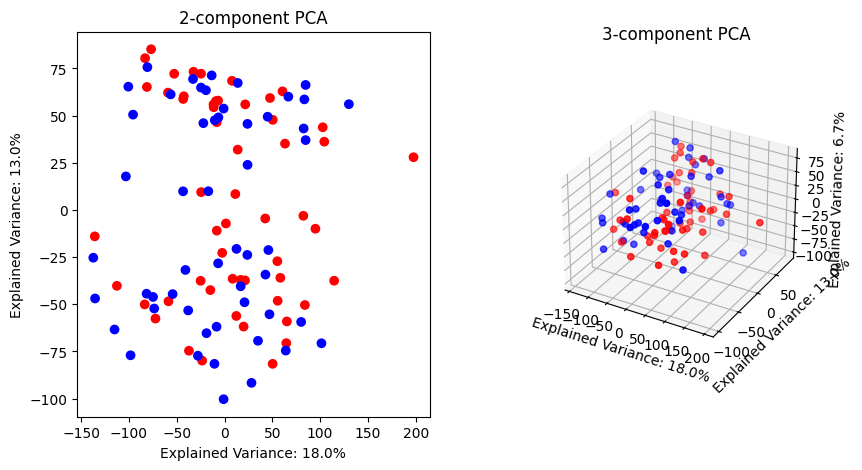

In [5]:
# Perform PCA of the dataset in 2 and 3 dimensions
from mpl_toolkits.mplot3d import Axes3D

# Make a PCA decomposition to 2 and 3 dimensions and show it as a plot
pca_2 = PCA(n_components=2)
pca_3 = PCA(n_components=3)

X_pca_2 = pca_2.fit_transform(X_scaled)
X_pca_3 = pca_3.fit_transform(X_scaled)

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=meta["Condition"].map({"Control": 'red', "Treatment": 'blue'}))
ax1.set_xlabel(f"Explained Variance: {pca_2.explained_variance_ratio_[0]*100:.1f}%")
ax1.set_ylabel(f"Explained Variance: {pca_2.explained_variance_ratio_[1]*100:.1f}%")
ax1.set_title("2-component PCA")

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.scatter(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], c=meta["Condition"].map({"Control": 'red', "Treatment": 'blue'}))
ax2.set_xlabel(f"Explained Variance: {pca_3.explained_variance_ratio_[0]*100:.1f}%")
ax2.set_ylabel(f"Explained Variance: {pca_3.explained_variance_ratio_[1]*100:.1f}%")
ax2.set_zlabel(f"Explained Variance: {pca_3.explained_variance_ratio_[2]*100:.1f}%")
ax2.set_title("3-component PCA")
ax2.set_box_aspect(None, zoom=0.75)

Text(0, 0.5, 'Cumulative explained variance [%]')

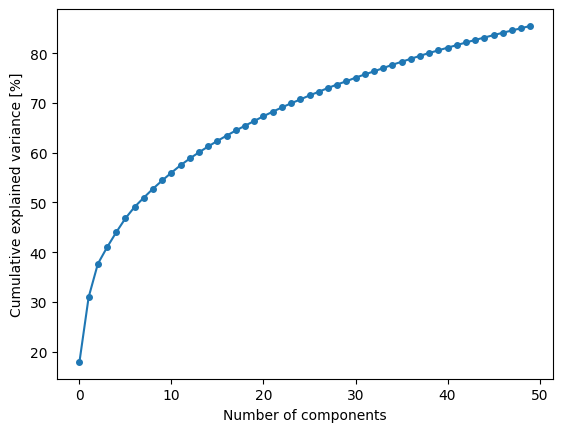

In [6]:
# Plot cumulative explained variance to determine optimal number of components
# What do you think about the data?
cev = []
for i in range(1, 51):
    pca = PCA(i)
    X_fit = pca.fit_transform(X_scaled)
    cev.append(sum(pca.explained_variance_ratio_)*100)

plt.plot(cev, marker="o", markersize=4, linestyle="solid")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance [%]")

## 4️⃣ t-SNE — t-distributed Stochastic Neighbor Embedding

2-component T-SNE:
no. of iterations: 949
KL-divergence: 0.356

3-component T-SNE:
no. of iterations: 999
KL-divergence: 1.428


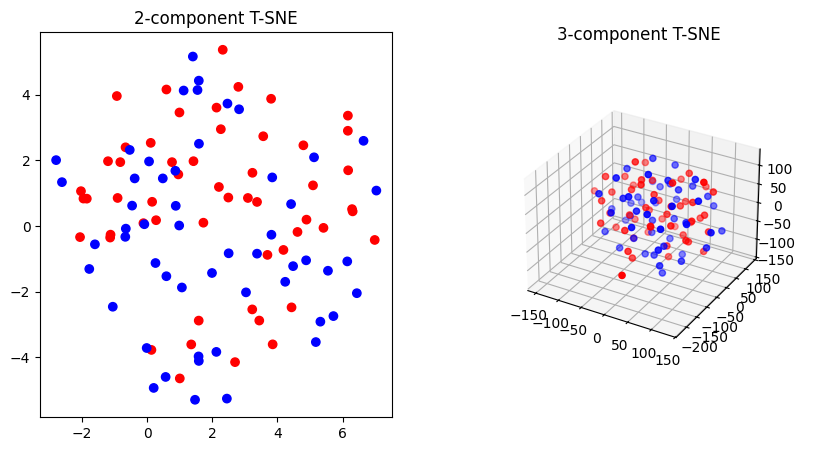

In [ ]:

# Perform t-SNE dimensionality reduction in 2D and 3D
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# perform t-SNE decomposition of X_scaled to 2 and 3 dimensions. 
# Calculate the number of iterations needed for convergence and KL-divergence
tsne_2 = TSNE(n_components=2)
tsne_3 = TSNE(n_components=3)

X_tsne_2 = tsne_2.fit_transform(X_scaled)
X_tsne_3 = tsne_3.fit_transform(X_scaled)

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(X_tsne_2[:, 0], X_tsne_2[:, 1], c=meta["Condition"].map({"Control": 'red', "Treatment": 'blue'}))
ax1.set_title("2-component T-SNE")

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.scatter(X_tsne_3[:, 0], X_tsne_3[:, 1], X_tsne_3[:, 2], c=meta["Condition"].map({"Control": 'red', "Treatment": 'blue'}))
ax2.set_title("3-component T-SNE")
ax2.set_box_aspect(None, zoom=0.75)

print(f"2-component T-SNE:")
print(f"no. of iterations: {tsne_2.n_iter_}")
print(f"KL-divergence: {tsne_2.kl_divergence_:0.3f}\n")

print(f"3-component T-SNE:")
print(f"no. of iterations: {tsne_3.n_iter_}")
print(f"KL-divergence: {tsne_3.kl_divergence_:0.3f}")

Computing t-SNE with different random seeds to assess stability...


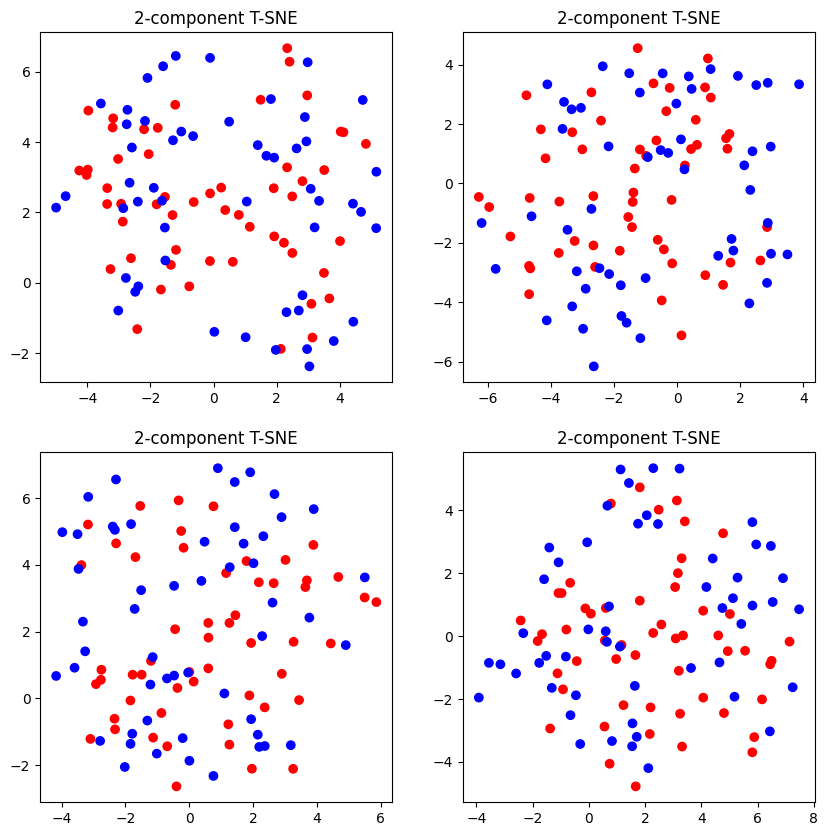

In [21]:
# TODO: Analyze t-SNE Stability Analysis: Different Random Seeds 
# Plot a 1x4 figure differing in seeds
print("Computing t-SNE with different random seeds to assess stability...")

# Use the same perplexity as before, different seeds
perplexity = min(30, (X_scaled.shape[0] - 1) // 3)
seeds = [42, 123, 456, 789]

fig = plt.figure(figsize=(10, 10))

for i in range(1, 5):
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X_scaled)
    ax = fig.add_subplot(2, 2, i)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=meta["Condition"].map({"Control": 'red', "Treatment": 'blue'}))
    ax.set_title("2-component T-SNE")

Computing t-SNE with different perplexities...


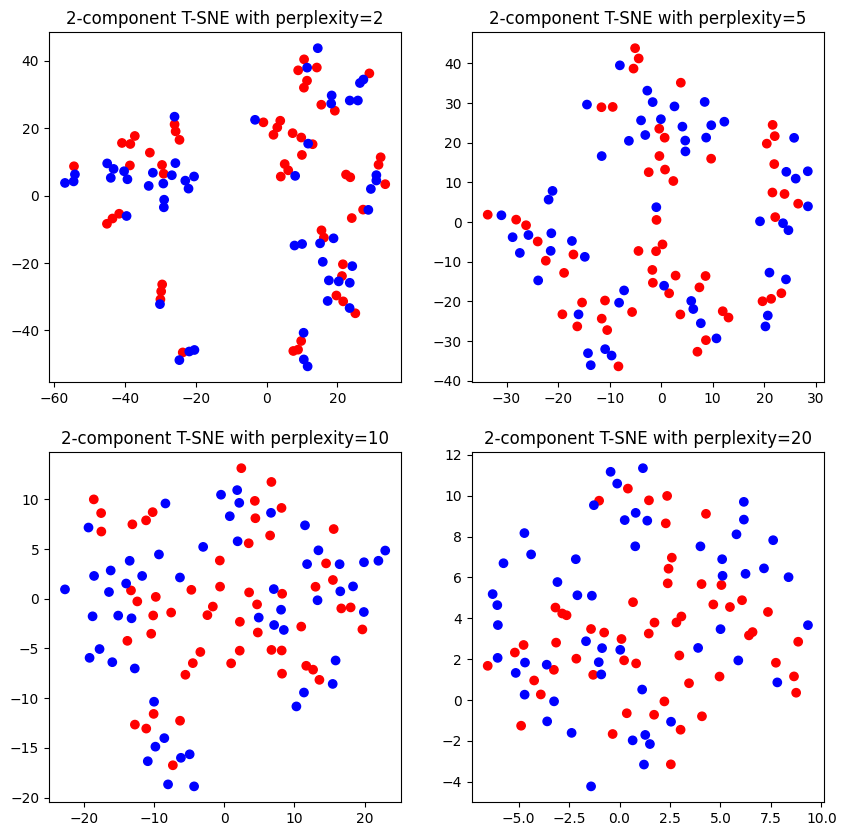

In [25]:
# TODO: t-SNE Parameter Analysis: Different Perplexity Values
# Do the same, but changing perplexity

print("Computing t-SNE with different perplexities...")

perplexities = [2, 5, 10, 20]
seeds = [42, 123, 456, 789]

fig = plt.figure(figsize=(10, 10))

for i in range(1, 5):
    tsne = TSNE(n_components=2, perplexity=perplexities[i-1])
    X_tsne = tsne.fit_transform(X_scaled)
    ax = fig.add_subplot(2, 2, i)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=meta["Condition"].map({"Control": 'red', "Treatment": 'blue'}))
    ax.set_title(f"2-component T-SNE with perplexity={perplexities[i-1]}")

## 5️⃣ UMAP — Uniform Manifold Approximation and Projection

In [28]:

# Perform UMAP dimensionality reduction in 2D and 3D
import umap
from mpl_toolkits.mplot3d import Axes3D

# TODO: Perform UMAP decompositino to 2 and 3 dimensions

print("Computing UMAP embeddings...")
print("UMAP is generally faster than t-SNE and preserves both local and global structure...")

# Calculate UMAP with 3 components to get both 2D and 3D projections
# UMAP parameters: n_neighbors (local neighborhood size) and min_dist (minimum distance between points)
n_neighbors = min(15, X_scaled.shape[0] - 1)  # Ensure n_neighbors doesn't exceed sample size
min_dist = 0.1  # Minimum distance between points in the embedding



ModuleNotFoundError: No module named 'umap'

## 6️⃣ Clustering — k-Means and Hierarchical

In [ ]:

# K-Means clustering on UMAP projection with different numbers of clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# TODO perform clustering of UMAP result to different cluster numbers. 
# Show the results as 2x3 grid
# calculate Silhouette scores for each clustering
print("Performing k-means clustering on UMAP projection...")

# Define different numbers of clusters to test
n_clusters_list = [2, 3, 4, 5, 8, 10]
silhouette_scores = []

# Create 2x3 subplot layout
plt.figure(figsize=(18, 12))


In [ ]:
# TODO: Silhouette Score Analysis: Plot silhouette score against number of clusters


In [ ]:
# TODO: Hierarchical Clustering: Plot dendrograms of UMAP result with different linkage methods
from scipy.cluster.hierarchy import linkage, dendrogram

print("Computing hierarchical clustering with different linkage methods...")

# Define different linkage methods
linkage_methods = ['ward', 'complete', 'average']
linkage_names = ['Ward', 'Complete', 'Average']


## 7️⃣ Autoencoder (PyTorch)

In [ ]:
# Create Mock Dataset for Autoencoder Compression
print("Creating mock dataset for autoencoder dimensionality reduction...")

# Set random seed for reproducibility
np.random.seed(42)

# Dataset parameters
n_samples = 200
n_features = 30

# Create base dataset with some structure
X = np.random.randn(n_samples, n_features)

# Add distinct patterns to create interesting structure
# Group 1: Add positive bias to first half of features
X[:n_samples//2, :n_features//2] += 2.0

# Group 2: Add negative bias to second half of features  
X[n_samples//2:, n_features//2:] -= 1.5

# Add some noise
X += np.random.normal(0, 0.3, X.shape)

# Standardize the data
X = StandardScaler().fit_transform(X)

# Create labels for visualization
labels = np.repeat(["Pattern A", "Pattern B"], n_samples // 2)
if n_samples % 2 == 1:
    labels = np.append(labels, ["Pattern A"])

print(f"Mock dataset created:")
print(f"  Shape: {X.shape}")
print(f"  Features: {n_features}")
print(f"  Samples: {n_samples}")
print(f"  Labels: {np.unique(labels, return_counts=True)}")

# Visualize the dataset structure
plt.figure(figsize=(12, 4))

# Plot 1: Feature means by group
plt.subplot(1, 2, 1)
group_a = X[labels == "Pattern A"]
group_b = X[labels == "Pattern B"]
plt.plot(np.mean(group_a, axis=0), 'b-', label='Pattern A', linewidth=2)
plt.plot(np.mean(group_b, axis=0), 'r-', label='Pattern B', linewidth=2)
plt.title("Mean Feature Values by Pattern")
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: First two features scatter plot
plt.subplot(1, 2, 2)
colors = (labels == "Pattern B").astype(int)
plt.scatter(X[:, 0], X[:, 1], c=colors, cmap="coolwarm", alpha=0.7, s=50)
plt.title("First Two Features")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()

print("Dataset ready for autoencoder compression!")


In [ ]:

# Autoencoder for nonlinear dimensionality reduction
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(), nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(), nn.Linear(64, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        x_rec = self.decoder(z)
        return x_rec, z

In [ ]:

# Simple Autoencoder Training with Mock Dataset
print("Creating mock dataset for autoencoder training...")
np.random.seed(42)
n_samples, n_features = 200, 30  # Small dataset for fast training
X_mock = np.random.randn(n_samples, n_features)
# Add some structure to make it more interesting
X_mock[:n_samples//2] += 1.5  # Create two distinct groups
X_mock = StandardScaler().fit_transform(X_mock)

# Create mock conditions
conditions_mock = np.repeat(["Group A", "Group B"], n_samples // 2)

# Initialize autoencoder with mock data
input_dim = X_mock.shape[1]
ae = Autoencoder(input_dim)
optimizer = optim.Adam(ae.parameters(), lr=0.01)
criterion = nn.MSELoss()
tensor_data = torch.tensor(X_mock, dtype=torch.float32)
loader = DataLoader(TensorDataset(tensor_data, tensor_data), batch_size=16, shuffle=True)

print("Training autoencoder for 20 epochs...")
# Train the autoencoder
ae.train()
losses = []
for epoch in range(20):
    epoch_loss = 0
    for x, _ in loader:
        optimizer.zero_grad()
        x_rec, _ = ae(x)
        loss = criterion(x_rec, x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(loader))
    if epoch % 5 == 0:
        print(f"Epoch {epoch:2d}, Loss: {losses[-1]:.4f}")

print("Training completed!")

# Extract latent representations
ae.eval()
with torch.no_grad():
    _, X_latent = ae(tensor_data)
    X_latent = X_latent.numpy()

# Plot results
plt.figure(figsize=(12, 5))

# Plot 1: Training loss
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True, alpha=0.3)

# Plot 2: Latent space
plt.subplot(1, 2, 2)
condition_colors_mock = (conditions_mock == "Group B").astype(int)
plt.scatter(X_latent[:, 0], X_latent[:, 1], c=condition_colors_mock, 
           cmap="coolwarm", alpha=0.7, s=50)
plt.title("Autoencoder Latent Space")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")

plt.tight_layout()
plt.show()

print(f"Final training loss: {losses[-1]:.4f}")
print(f"Latent space shape: {X_latent.shape}")
print("The autoencoder successfully learned a 2D representation!")



## ✅ Summary

In this lab you learned how to:
- Represent and scale gene expression data (RNA-seq)
- Apply PCA for variance-based projections
- Understand t-SNE and UMAP for nonlinear embeddings
- Cluster biological samples (k-Means, hierarchical)
- Use (and mock) autoencoders for deep feature compression

Next steps:
➡ Integrate these visualizations into multi-omics datasets  
➡ Use the embeddings for **classification and biomarker discovery**
